#TODO: figure out how I can integrate the knowledge of last sleep stage into my research

# Utilities

In [1]:
import numpy as np
import scipy as spy
import pandas as pd
from pathlib import Path
import mne
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import pingouin as pg

In [2]:
def read_dream_interpretation(path: Path):
    interpretation = pd.read_csv(path, sep=',')
    return interpretation

In [3]:
def read_eeg(path:Path):
    raw = mne.io.read_raw_edf("./data/PSG/"+path, preload=True, verbose=False)

    data, times = raw.get_data(return_times=True)
    ch_names = raw.ch_names
    
    df = pd.DataFrame(data.T, columns=ch_names)
    df["time_s"] = times
    return df


In [4]:
def plot_dataframe_signals(df: pd.DataFrame, title: str, max_samples = None, time_col: str = None):
    sns.set_style("whitegrid")

    df_plot = df.copy()
    
    if max_samples != None and max_samples < len(df_plot):
        new_indices = np.linspace(0, len(df_plot), max_samples, endpoint=False, dtype=np.int32)
        df_plot = df_plot.iloc[new_indices]

    if time_col and time_col in df_plot.columns:
        x = df_plot[time_col].values
        xlabel = "Time [s]"
        df_plot = df_plot.drop(columns=[time_col])
    else:
        x = np.arange(len(df_plot))
        xlabel = "Samples"
    

    numeric_cols = df_plot.select_dtypes(include=[np.number]).columns

    plt.figure(figsize=(15, 6))
    for col in numeric_cols:
        sns.lineplot(x=x, y=df_plot[col], label=col)

    plt.title(title, fontsize=14, weight="bold")
    plt.xlabel(xlabel)
    plt.ylabel("Amplitude")
    plt.legend(title="Channels", loc="best")
    plt.grid(True, which="major", linestyle="--", alpha=0.6)
    plt.grid(True, which="minor", linestyle=":", alpha=0.3)
    plt.gca().set_facecolor("lightblue")

    plt.tight_layout()
    plt.show()


In [5]:
def plot_dataframe_fft(df: pd.DataFrame, title: str, fs: float = None, time_col: str = None):
    sns.set_style("whitegrid")
    df_plot = df.copy()

    if time_col and time_col in df_plot.columns:
        time = df_plot[time_col].values
        df_plot = df_plot.drop(columns=[time_col])
        if fs is None:
            if len(time) > 1:
                fs = 1.0 / np.mean(np.diff(time))
                print(f"Inferred sampling frequecny: {fs}")
            else:
                raise ValueError("Not enough time samples to infer sampling frequency.")
    elif fs is None:
        raise ValueError("Sampling frequency 'fs' must be provided if no time column is given.")

    numeric_cols = df_plot.select_dtypes(include=[np.number]).columns
    n = len(df_plot)

    freqs = spy.fft.rfftfreq(n, d=1/fs)

    plt.figure(figsize=(15, 6))
    for col in numeric_cols:
        sig = df_plot[col].values
        fft_vals = spy.fft.rfft(sig)
        amplitude = np.abs(fft_vals) / (n / 2)
        amplitude = 10 * np.log10(amplitude + 1e-20)
        sns.lineplot(x=freqs, y=amplitude, label=col)

    plt.title(title + " — Amplitude Spectrum", fontsize=14, weight="bold")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Amplitude [dB]")
    plt.legend(title="Channels", loc="best")
    plt.grid(True, which="major", linestyle="--", alpha=0.6)
    plt.grid(True, which="minor", linestyle=":", alpha=0.3)
    plt.gca().set_facecolor("lightblue")
    plt.tight_layout()
    plt.show()


In [6]:
def extract_brain_frequency(df : pd.DataFrame, fs, bPass, bStop, maxLoss, minAttenuation):
    ord, w = spy.signal.cheb1ord(bPass, bStop, maxLoss, minAttenuation, analog=False, fs=fs)
    
    f_type = "bandpass"
    if len(bStop) == 1:
        if(bPass[0] < bStop[0]):
            f_type = "lowpass"
        elif(bPass[0] > bStop[0]):
            f_type = "highpass"
    
    ripple = 3
    b, a = spy.signal.cheby1(ord, ripple, w, analog=False, fs=fs, btype=f_type)
    
    print(f"Filter order: {ord}")
    
    for i, column in enumerate(df.columns):
        df.iloc[:,i] = spy.signal.lfilter(b, a, df[column])
   
    return df
    

In [36]:
def get_subject_prefixes(subjects : np.array):
    prefixes = [x.split('.')[1] for x in subjects]
    return np.array(prefixes)

In [8]:
def apply_window(df : pd.DataFrame):
    kaiser_window = spy.signal.windows.get_window(("kaiser", 2), len(df))
    for idx, column in enumerate(df.columns):
        df.iloc[:, idx] = kaiser_window * df[column]
        
    return df

In [9]:
def get_rid_of_bad_channels(patient_recording_id : str, patient_recording : pd.DataFrame, recordings_meta : pd.DataFrame):
    bad_channels_str = recordings_meta[recordings_meta["Filename"] == f"{patient_recording_id}.edf"]["Bad channels"].to_string().strip()

    try:
        bad_channels = [int(k)-1 for k in bad_channels_str.split()[1:]] #channels are indexed from 1 + index must be removed
    except:
        bad_channels = []
        pass
    
    print(f"Bad eeg channels: {patient_recording.columns[bad_channels]}")
    
    good_channels = []
    for i in range(7):
        if i not in bad_channels:
            good_channels.append(patient_recording.columns[i])
            
    good_channels = sorted(good_channels)
            
    print(f"Good eeg channels: {good_channels}")
            
    patient_recording.drop(columns=patient_recording.columns[bad_channels], inplace=True)
    
    #removing line noise
    fs=250
    ord, w = spy.signal.buttord([48, 51], [49.5, 50.5], 1, 10, analog=False, fs=fs)
    print(f"Line filter order: {ord}")
    b, a = spy.signal.butter(ord, w, analog=False, fs=fs, btype="bandstop")
        
    for idx, column in enumerate(patient_recording.columns):
        patient_recording.iloc[:, idx] = spy.signal.lfilter(
            b, a, patient_recording[column].to_numpy()
        )

    
    return good_channels

In [10]:
def plot_dreem_topomap(metrics, channel_names, fs=128, title="Topomap", value_label="Some stupid value"):
    """
    Plot a topomap for DREEM bipolar signals using midpoint-based electrode positions.
    """

    montage_1020 = mne.channels.make_standard_montage("standard_1020")
    pos_std = montage_1020.get_positions()["ch_pos"]

    # Compute midpoint
    def midpoint(a, b):
        return (pos_std[a] + pos_std[b]) / 2

    dreem_positions = {
        "EEG Fp1-O1": midpoint("Fp1", "O1"),
        "EEG Fp1-O2": midpoint("Fp1", "O2"),
        "EEG Fp1-F7": midpoint("Fp1", "F7"),
        "EEG F8-F7":  midpoint("F8", "F7"),
        "EEG F7-O1": midpoint("F7", "O1"),
        "EEG F8-O2": midpoint("F8", "O2"),
        "EEG Fp1-F8": midpoint("Fp1", "F8")
    }

    used_positions = {ch: dreem_positions[ch] for ch in channel_names}

    dig_montage = mne.channels.make_dig_montage(
        ch_pos=used_positions,
        coord_frame="head"
    )

    info = mne.create_info(
        ch_names=list(used_positions.keys()),
        sfreq=fs,
        ch_types="eeg"
    )
    info.set_montage(dig_montage)

    fig, ax = plt.subplots(figsize=(6, 5))
    im, _ = mne.viz.plot_topomap(
        np.asarray(metrics),
        pos=info,             
        axes=ax,
        cmap="viridis",
        show=False
    )

    ax.set_title(title)
    plt.colorbar(im, ax=ax, label=value_label)
    plt.show()


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import mne
import re

%matplotlib widget

def animate_dreem_topomap(metrics_time,
                          channel_names,
                          fs=128,
                          title="Animated Topomap",
                          value_label="Some stupid value",
                          interval=100,
                          save=False,
                          fps=15,
                          format="gif"):
    """
    Animate topomap for DREEM bipolar EEG signals.

    Parameters
    ----------
    metrics_time : np.ndarray
        (time, n_channels)
    channel_names : list
        Channel labels
    save : bool
        Save to file if True
    format : str
        'gif' or 'mp4'
    """

    metrics_time = np.asarray(metrics_time)
    n_time, n_ch = metrics_time.shape

    if len(channel_names) != n_ch:
        raise ValueError("Number of channel names must match metrics_time.shape[1]")

    safe_title = re.sub(r'[^a-zA-Z0-9_\- ]', '', title).replace(" ", "_")

    # --------- Standard 10–20 positions ---------
    montage_1020 = mne.channels.make_standard_montage("standard_1020")
    pos_std = montage_1020.get_positions()["ch_pos"]

    def midpoint(a, b):
        return (pos_std[a] + pos_std[b]) / 2

    dreem_positions = {
        "EEG Fp1-O1": midpoint("Fp1", "O1"),
        "EEG Fp1-O2": midpoint("Fp1", "O2"),
        "EEG Fp1-F8": midpoint("Fp1", "F8"), #frontal right
        "EEG Fp1-F7": midpoint("Fp1", "F7"), #frontal left
        
        "EEG F8-F7":  midpoint("F8", "F7"),
        "EEG F8-O2":  midpoint("F8", "O2"),
        
        "EEG F7-O1":  midpoint("F7", "O1"),
    }

    used_positions = {ch: dreem_positions[ch] for ch in channel_names}

    dig_montage = mne.channels.make_dig_montage(
        ch_pos=used_positions,
        coord_frame="head"
    )

    info = mne.create_info(
        ch_names=list(used_positions.keys()),
        sfreq=fs,
        ch_types="eeg"
    )
    info.set_montage(dig_montage)

    vmin = np.min(metrics_time)
    vmax = np.max(metrics_time)

    fig, ax = plt.subplots(figsize=(6, 5))

    im, _ = mne.viz.plot_topomap(
        metrics_time[0],
        pos=info,
        axes=ax,
        show=False,
        cmap="viridis",
        vlim=(vmin, vmax)
    )

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(value_label)

    ax.set_title(f"{title}\nFrame: 0")

    def update(frame):
        ax.clear()

        im, _ = mne.viz.plot_topomap(
            metrics_time[frame],
            pos=info,
            axes=ax,
            show=False,
            cmap="viridis",
            vlim=(vmin, vmax)
        )

        ax.set_title(f"{title}\nFrame: {frame}")
        return [im]

    ani = animation.FuncAnimation(
        fig,
        update,
        frames=n_time,
        interval=interval,
        blit=False,
        repeat=False
    )

    if save:
        if format.lower() == "gif":
            from matplotlib.animation import PillowWriter
            writer = PillowWriter(fps=fps)
            filename = f"{safe_title}.gif"
            ani.save(filename, writer=writer)

        elif format.lower() == "mp4":
            from matplotlib.animation import FFMpegWriter
            writer = FFMpegWriter(fps=fps, bitrate=1800)
            filename = f"{safe_title}.mp4"
            ani.save(filename, writer=writer)

        else:
            raise ValueError("format must be 'gif' or 'mp4'")

    plt.show()
    return ani


In [12]:
def compute_psd(df : pd.DataFrame, fs, window, window_duration, overlap_ratio, freq_band, use_db = True, normalize_power = False) -> pd.DataFrame :    
    win_point_length = int(fs 
                           * window_duration)
    win_point_overlap = int(win_point_length * overlap_ratio)

    mean_psds = {} 

    for signal in df.columns:
        f, t, Sxx = spy.signal.spectrogram(
            df[signal],
            fs=fs,
            window=window,
            nperseg=win_point_length,
            noverlap=win_point_overlap,
            scaling='density',
            mode='psd',
            return_onesided=True
        )
        
        f_low, f_high = freq_band
        band_mask = (f >= f_low) & (f <= f_high)
        band_avg_psd = np.mean(Sxx[band_mask, :], axis=0)
                
        if use_db:
            band_avg_psd = 10 * np.log10(band_avg_psd + 1e-20)
        mean_psds[signal] = band_avg_psd
        
    mean_as_dict = pd.DataFrame.from_dict(mean_psds)
    
    if normalize_power:
        mean_psd_np = mean_as_dict.to_numpy() #this sucks but we are doing python after all
        norms = np.linalg.norm(mean_psd_np, axis=1)
        mean_psd_np = mean_psd_np / norms[:, None]
        mean_as_dict = pd.DataFrame(mean_psd_np)
        mean_as_dict.columns = df.columns
            
    mean_as_dict.set_index(t, inplace=True) 

    return mean_as_dict

In [13]:
def plot_mean_spectral_density(
    signals_df: pd.DataFrame, 
    fs: float, 
    window: str, 
    window_duration: float, 
    overlap_ratio: float, 
    freq_band: tuple, 
    use_db: bool = True
):  
    win_point_length = int(fs * window_duration)
    win_point_overlap = int(win_point_length * overlap_ratio)

    sns.set_style("whitegrid")
    fig, ax = plt.subplots(1, 1, figsize=(20, 6))

    f_low, f_high = freq_band
    
    ylabel = "Average PSD [dB/Hz]" if use_db else "Average PSD [V²/Hz]"
    title = f"Average PSD in {f_low:.1f}-{f_high:.1f} Hz Band"

    for signal_name in signals_df.columns:
        signal = signals_df[signal_name].values
        
        f, t, Sxx = spy.signal.spectrogram(
            signal,
            fs=fs,
            window=window,
            nperseg=win_point_length,
            noverlap=win_point_overlap,
            scaling='density',
            mode='psd',
            return_onesided=True
        )

        band_mask = (f >= f_low) & (f <= f_high)
        band_avg_psd = np.mean(Sxx[band_mask, :], axis=0)
        
        if use_db:
            band_avg_psd_to_plot = 10 * np.log10(band_avg_psd + 1e-20)
        else:
            band_avg_psd_to_plot = band_avg_psd
            
        ax.plot(
            t, 
            band_avg_psd_to_plot, 
            linewidth=1.8, 
            label=signal_name
        )
        
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Time [s]", fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_facecolor("whitesmoke")
    ax.legend(title="Signals", loc="best") 

    plt.tight_layout()
    plt.show()

# Common

In [77]:
interpretation = read_dream_interpretation("./data/reports_interpreted.csv")
meta = pd.read_csv("./data/Records.csv")
eeg_channels_names = sorted(
    [
        "EEG Fp1-O1",
        "EEG Fp1-O2",
        "EEG Fp1-F8",
        "EEG Fp1-F7",
        "EEG F8-F7",
        "EEG F8-O2",
        "EEG F7-O1",
    ]
)

stage_to_int = {"N2":2, "REM":5, "N1":1}

studied_stage = stage_to_int["N2"]

In [79]:
nightmare_subjects = interpretation[interpretation["Classification"] == "Nightmare"]
nightmare_subjects = nightmare_subjects[nightmare_subjects["Stage"] == studied_stage]
num_nightmare_subjects = len(nightmare_subjects)
nightmare_records = get_subject_prefixes(nightmare_subjects["Source File"].to_numpy())
print(f"Num nightmare entries: {num_nightmare_subjects}. \n")

neutral_subjects = interpretation[interpretation["Classification"] == "Neutral"]
neutral_subjects = neutral_subjects[neutral_subjects["Stage"] == studied_stage]
num_neutral_subjects = len(neutral_subjects)
neutral_records = get_subject_prefixes(neutral_subjects["Source File"].to_numpy())
print(f"Num neutral entries: {num_neutral_subjects}. \n")

positive_subjects = interpretation[interpretation["Classification"] == "Positive"]
positive_subjects = positive_subjects[positive_subjects["Stage"] == studied_stage]
num_positive_subjects = len(positive_subjects)
positive_records = get_subject_prefixes(positive_subjects["Source File"].to_numpy())
print(f"Num positive entries: {num_positive_subjects}. \n")

unpleasant_subjects = interpretation[interpretation["Classification"] == "Unpleasant/Anxious"]
unpleasant_subjects = unpleasant_subjects[unpleasant_subjects["Stage"] == studied_stage]
num_unpleasant_subjects = len(unpleasant_subjects)
unpleasant_records = get_subject_prefixes(unpleasant_subjects["Source File"].to_numpy())
print(f"Num unpleasant entries: {num_unpleasant_subjects}. \n")

Num nightmare entries: 4. 

Num neutral entries: 25. 

Num positive entries: 7. 

Num unpleasant entries: 30. 



In [66]:
# aug_names = [name[1:] + ".edf" for name in positive_records]
# print(aug_names)

# subj = meta[meta["Filename"].isin(aug_names)] 

# subj.to_csv("tmp.csv")

# print(subj["Filename"])

# print(subj["Last sleep stage"].to_numpy())

# Tests

In [17]:
subject_name = "DL014/DL014_night03"
subject = read_eeg(f"/{subject_name}.edf")

In [18]:
available_eeg_channels = get_rid_of_bad_channels(subject_name, subject, meta)

Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3


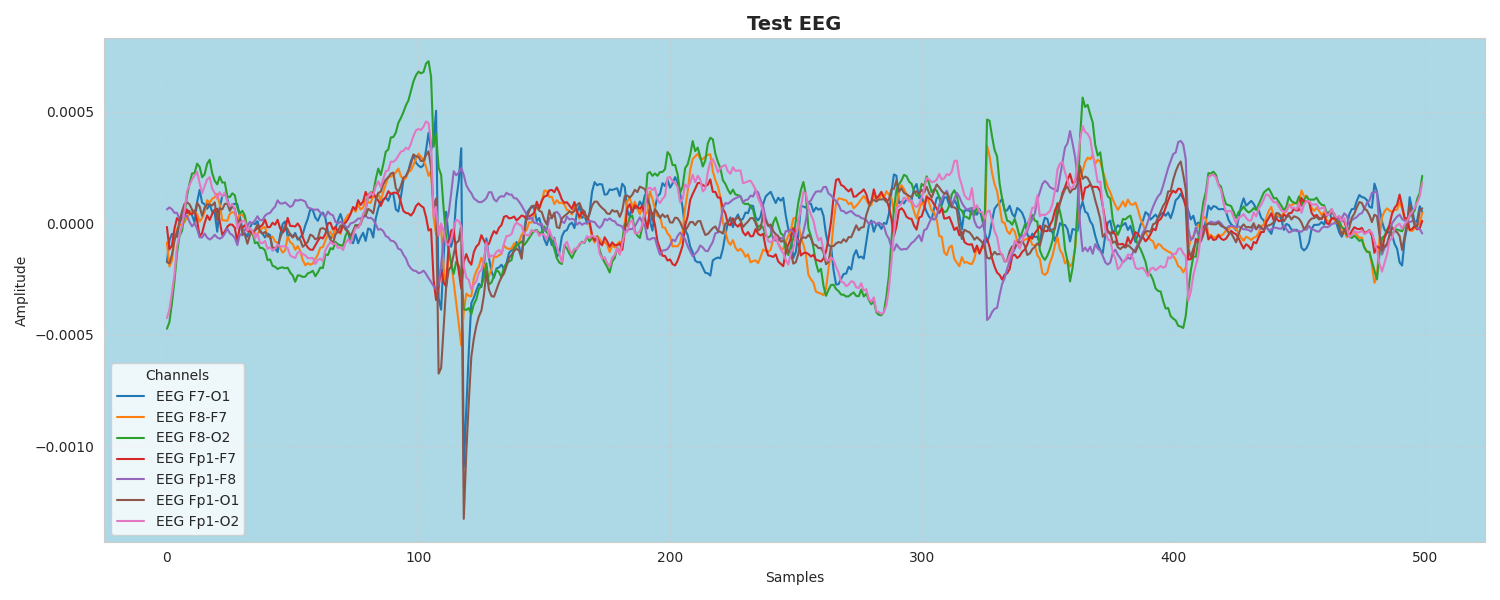

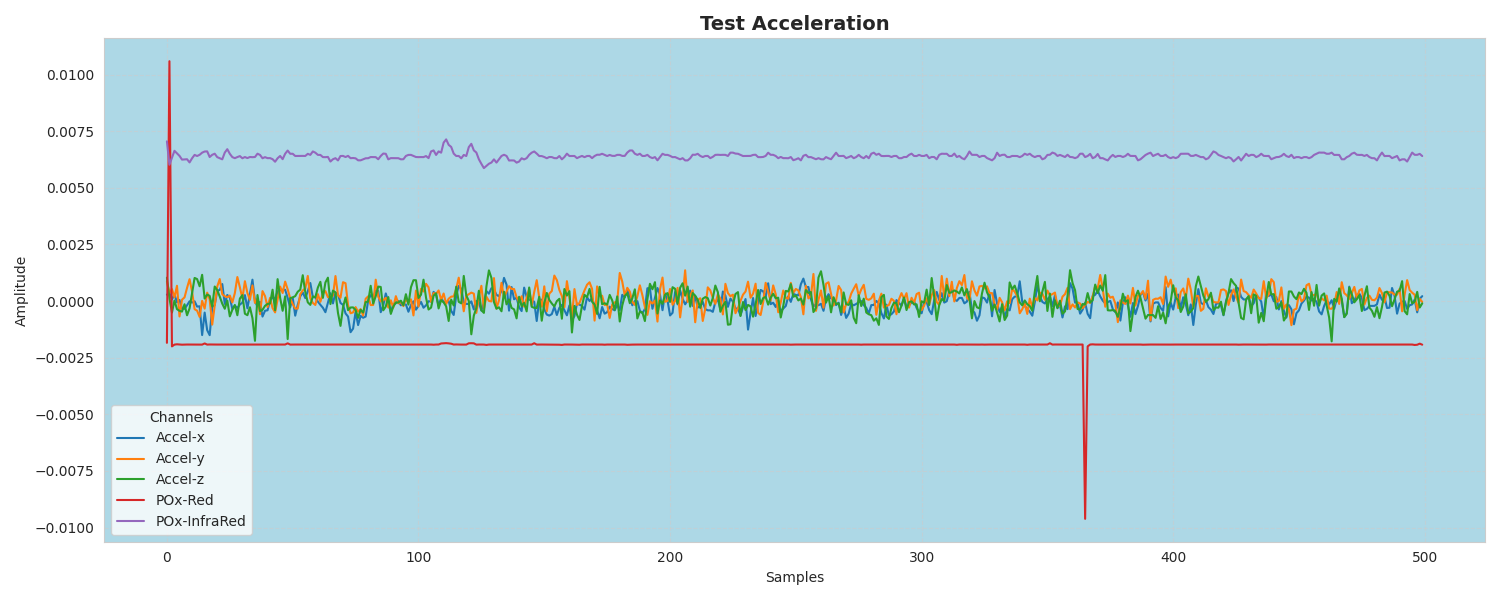

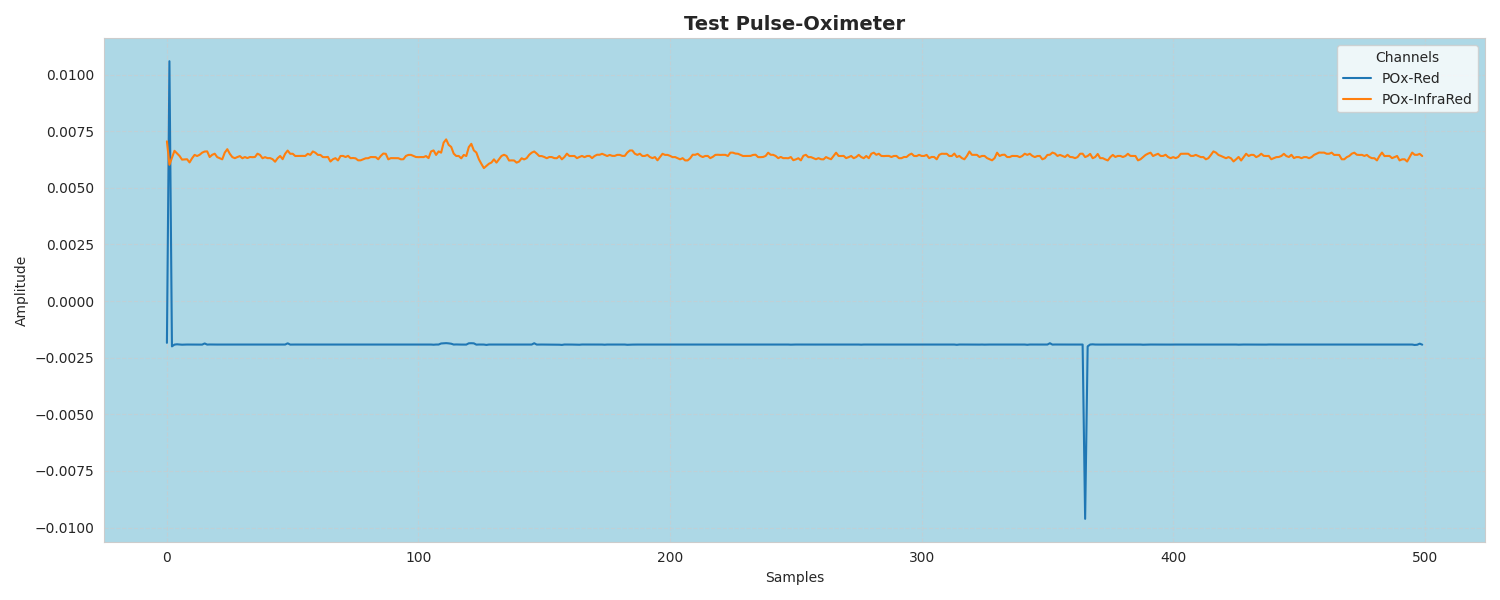

In [19]:
plot_dataframe_signals(
    subject[
        available_eeg_channels
    ],
    "Test EEG",
    500,
    None,
)
plot_dataframe_signals(
    subject[["Accel-x", "Accel-y", "Accel-z", "POx-Red", "POx-InfraRed"]],
    "Test Acceleration",
    500,
    None,
)

plot_dataframe_signals(
    subject[["POx-Red", "POx-InfraRed"]],
    "Test Pulse-Oximeter",
    500,
    None,
)

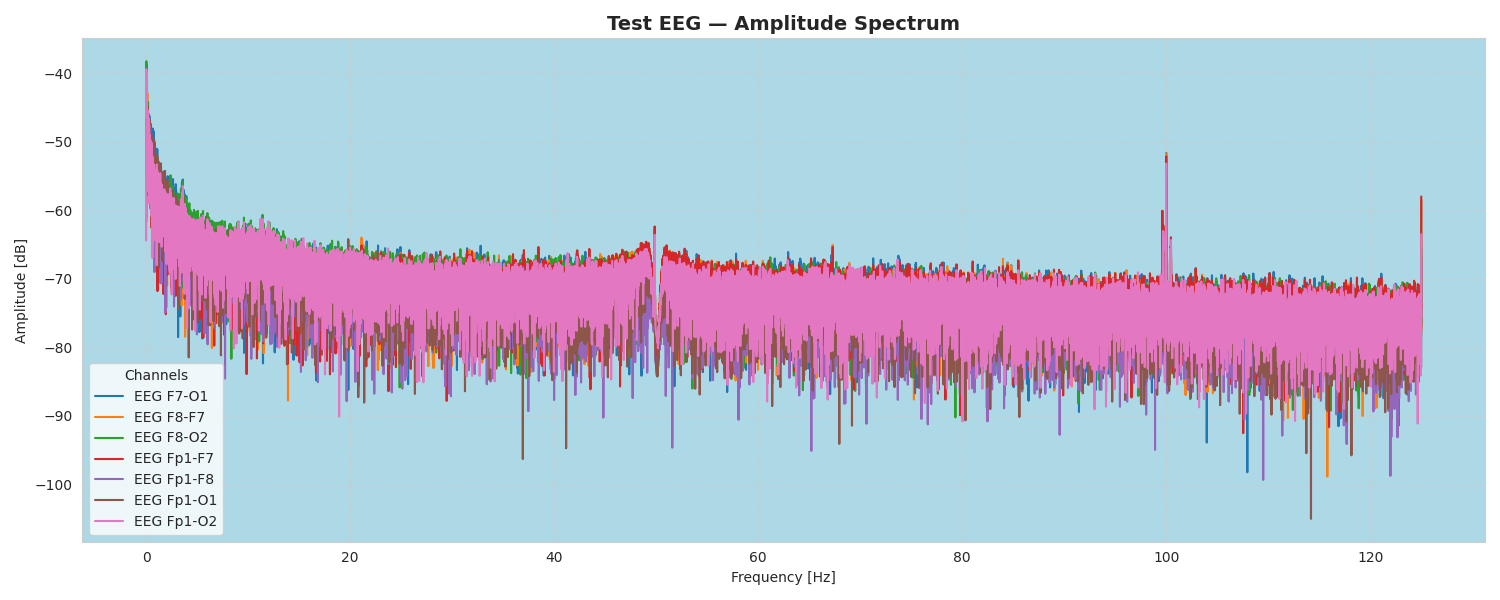

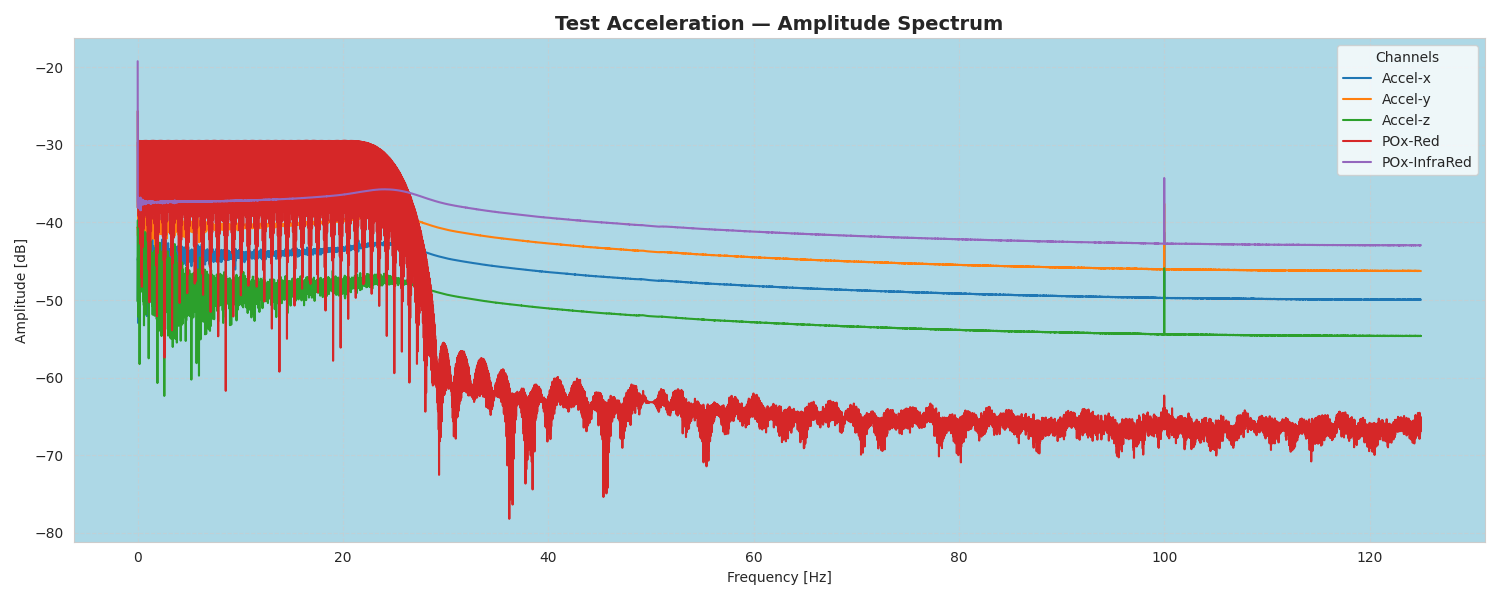

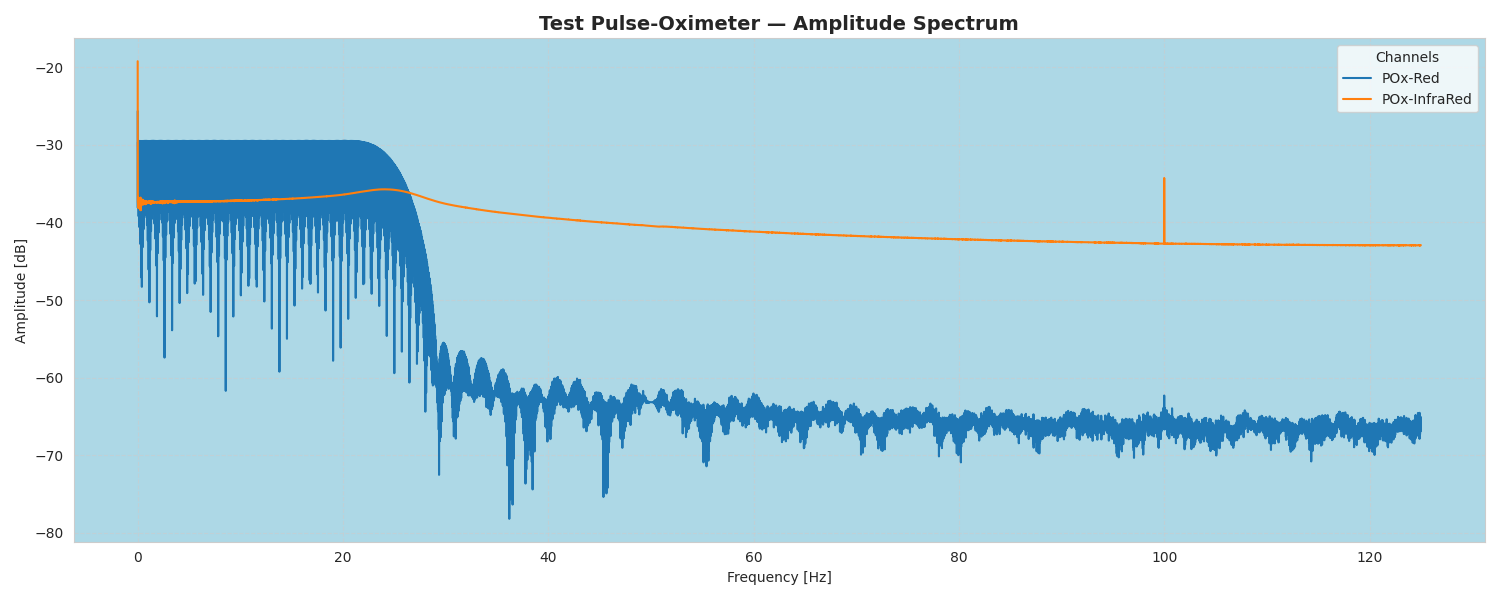

In [20]:
plot_dataframe_fft(
    subject[
        available_eeg_channels
    ],
    "Test EEG",
    250,
    None,
)
plot_dataframe_fft(
    subject[["Accel-x", "Accel-y", "Accel-z", "POx-Red", "POx-InfraRed"]],
    "Test Acceleration",
    250,
    None,
)

plot_dataframe_fft(
    subject[["POx-Red", "POx-InfraRed"]],
    "Test Pulse-Oximeter",
    250,
    None,
)

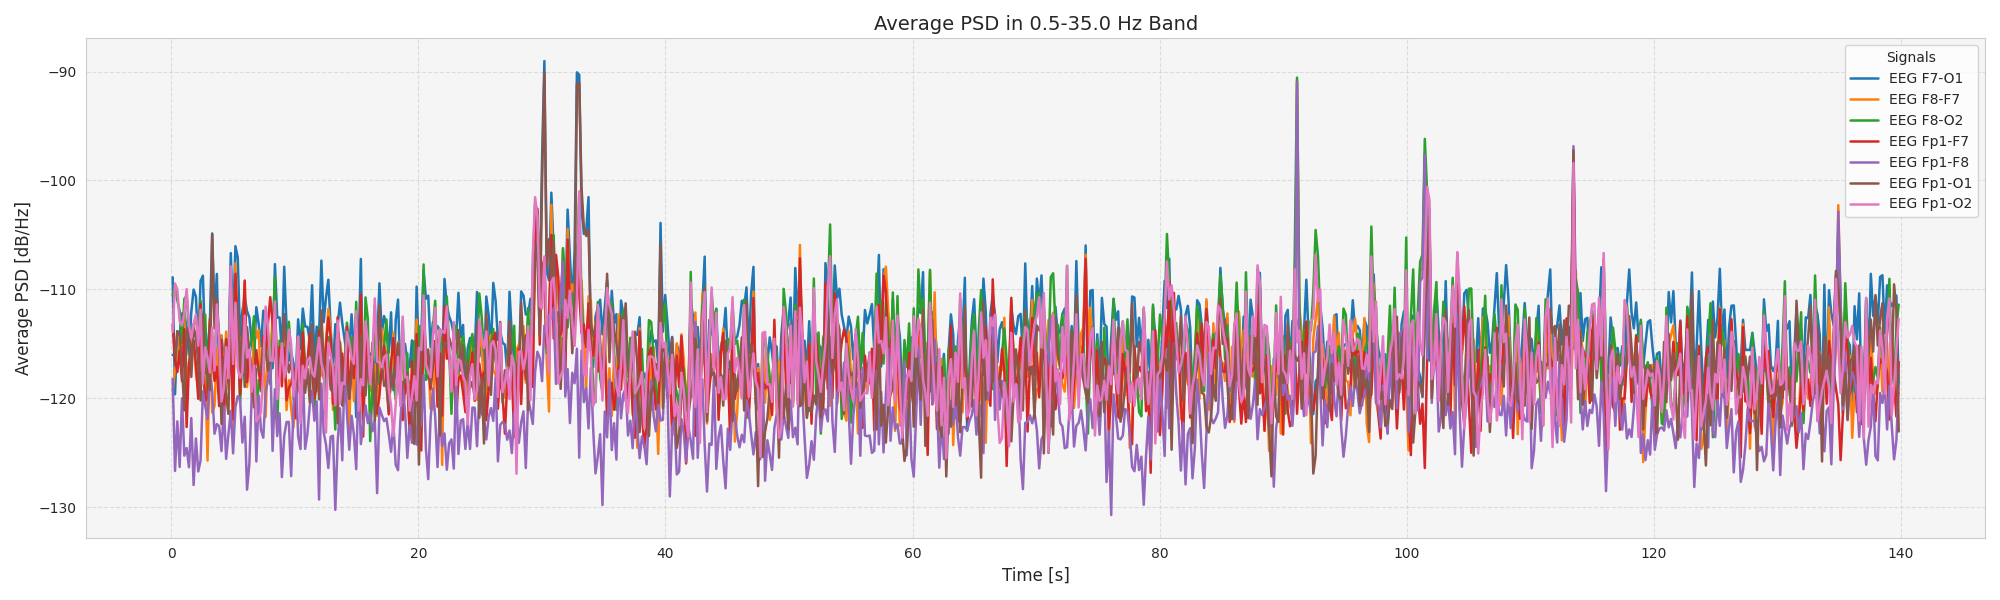

In [21]:
plot_mean_spectral_density(subject[available_eeg_channels], 250, "hamming", 0.25, 0.25, (0.5, 35))

Filter order: 4
(744, 7)
['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
(7,)


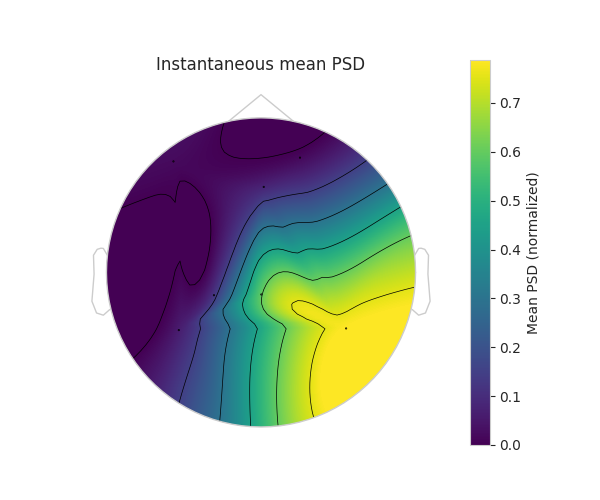

In [22]:
frequency_of_interest = extract_brain_frequency(subject[available_eeg_channels], 250, [8, 12], [7,13], 2, 15)
windowed_frequency = apply_window(frequency_of_interest)

mean_psd = compute_psd(windowed_frequency, 250, "hamming", 0.25, 0.25, (0.5, 35), False)

print(mean_psd.to_numpy().shape)

time_slice = mean_psd.to_numpy()[0,:]  #rows - time, cols - channels
time_slice = time_slice / np.linalg.norm(time_slice)

print(available_eeg_channels)
print(time_slice.shape)

plot_dreem_topomap(time_slice, available_eeg_channels, fs=250, title="Instantaneous mean PSD", value_label="Mean PSD (normalized)")


(744,)
(744, 7)


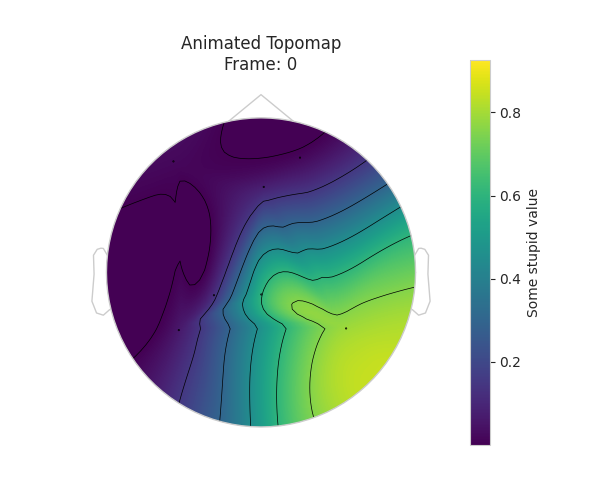

In [23]:
mean_psd_np = mean_psd.to_numpy()
norms = np.linalg.norm(mean_psd_np, axis=1)

print(norms.shape)

mean_psd_np = mean_psd_np / norms[:, None]

print(mean_psd_np.shape)

animate_dreem_topomap(mean_psd_np, available_eeg_channels, fs=250, save=False, fps=5, interval=250)

# Statistics computation

In [24]:
subject_name = "DL014/DL014_night03"
subject = read_eeg(f"/{subject_name}.edf")
available_eeg_channels = get_rid_of_bad_channels(subject_name, subject, meta)
print(available_eeg_channels)

Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']


### Mean PSD

Filter order: 4
(813, 7)


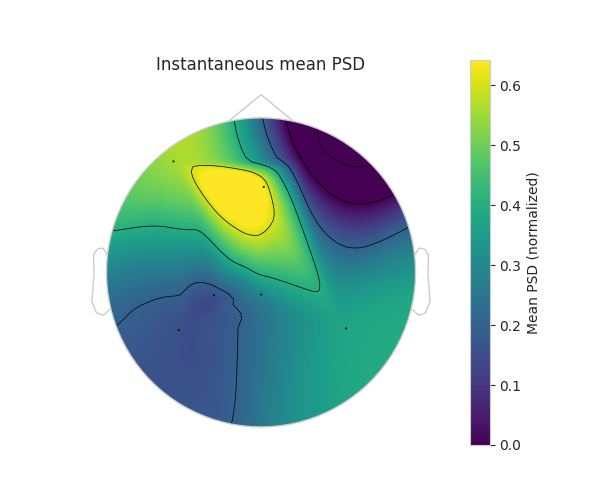

Filter order: 4
(813, 7)


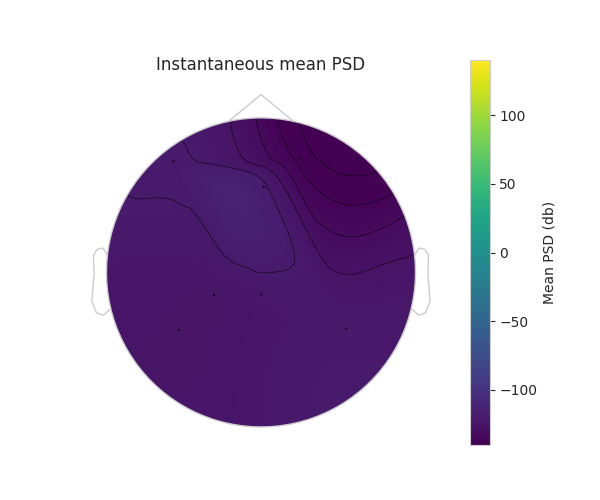

In [25]:
def obtain_mean_psd(bandpass, bandstop, subject_name, use_db = False, normalize = False):
    subject_psd = read_eeg(f"/{subject_name}.edf")
    frequency_of_interest = extract_brain_frequency(subject_psd[available_eeg_channels], 250, bandpass, bandstop, 2, 15)
    windowed_frequency = apply_window(frequency_of_interest)

    mean_psd = compute_psd(windowed_frequency, 250, "hamming", 0.2, 0.15, bandpass, use_db, normalize)  
    print(mean_psd.shape)
  
    return mean_psd

mean_psd = obtain_mean_psd([8, 12], [7,13], subject_name, False, True)
time_slice = mean_psd.to_numpy()[10,:]  #rows - time, cols - channels

plot_dreem_topomap(time_slice, available_eeg_channels, fs=250, title="Instantaneous mean PSD", value_label="Mean PSD (normalized)")

mean_psd = obtain_mean_psd([8, 12], [7,13], subject_name, True, False)
time_slice = mean_psd.to_numpy()[10,:]  #rows - time, cols - channels

plot_dreem_topomap(time_slice, available_eeg_channels, fs=250, title="Instantaneous mean PSD", value_label="Mean PSD (db)")


### FAA

Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 4


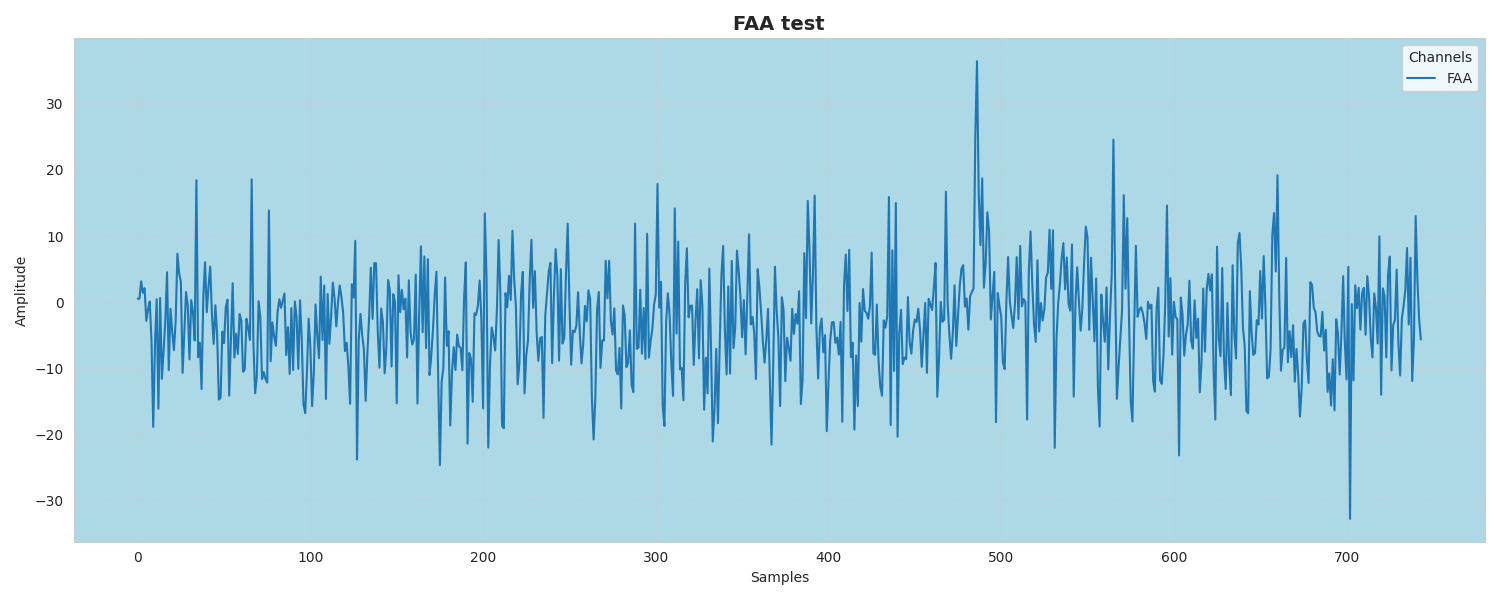

In [26]:
def obtain_faa(subject_name, detrend_faa = False):
    subject_faa = read_eeg(f"/{subject_name}.edf")
    available_eeg_channels = get_rid_of_bad_channels(subject_name, subject_faa, meta)
    alpha_frequency = extract_brain_frequency(subject_faa[available_eeg_channels], 250, [8, 12], [7,13], 2, 15)
    windowed_alpha = apply_window(alpha_frequency)
    mean_alpha_power = compute_psd(windowed_alpha, 250, "hamming", 0.25, 0.25, (8, 12), True, normalize_power=False)[ ["EEG Fp1-F8",
    "EEG Fp1-F7"] ] #log but do not normalize

    # "EEG Fp1-F8" - #frontal right
    # "EEG Fp1-F7" - #frontal left

    faa = mean_alpha_power["EEG Fp1-F8"] - mean_alpha_power["EEG Fp1-F7"] 
    
    if detrend_faa:
        faa = spy.signal.detrend(faa, type='linear')
    
    return faa

faa = obtain_faa(subject_name)
plot_dataframe_signals( pd.DataFrame.from_dict({"FAA":faa}) ,"FAA test")


### Activation index

In [27]:
def obtain_activation_index(subject_name):
    #compute beta power
    subject_b = read_eeg(f"/{subject_name}.edf")
    available_b_eeg_channels = get_rid_of_bad_channels(subject_name, subject_b, meta)
    subject_b = subject_b.astype("float128")
    beta_frequency = extract_brain_frequency(subject_b[available_b_eeg_channels], 250, [15, 30], [13, 32], 0.5, 16)
    windowed_beta = apply_window(beta_frequency)
    mean_beta_power = compute_psd(windowed_beta, 250, "hamming", 0.25, 0.25, (15, 30), True)

    #compute delta power
    subject_d = read_eeg(f"/{subject_name}.edf")
    subject_d = subject_d.astype("float128")
    delta_frequency = extract_brain_frequency(subject_d[available_b_eeg_channels], 250, [0.5, 4], [0.007, 5], 0.5, 16)
    windowed_delta = apply_window(delta_frequency)
    mean_delta_power = compute_psd(windowed_delta, 250, "hamming", 0.25, 0.25, (0.5, 4.5), True)

    ai = mean_delta_power / mean_beta_power 
    return ai
test_ai = obtain_activation_index(subject_name)
print(test_ai)

Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5
         EEG F7-O1  EEG F8-F7  EEG F8-O2  EEG Fp1-F7  EEG Fp1-F8  EEG Fp1-O1  \
0.124     0.992992   1.004977   0.991399    1.033040    0.996970    0.997301   
0.312     0.838409   0.836868   0.815738    0.866170    0.856540    0.829101   
0.500     0.801878   0.866690   0.809400    0.948966    0.834361    0.837750   
0.688     0.871597   0.900341   0.925785    0.877555    0.905793    0.921974   
0.876     0.931823   0.929336   0.879974    0.947961    0.996156    0.962845   
...            ...        ...        ...         ...         ...         ...   
139.056 -27.121219 -26.584571 -25.517522  -27.316810  -25.660345  -26.215755   
139.244 -27.237013 -26.744014 -27.692872  -26.573207  -25.714410  -27.307220   
139.432 -27.306802 -26.836435 -27.314930  -26.258559  -26.102115  -2

In [28]:
def obtain_region_coherence(subject_name, bandpass, bandstop):
    subject_c = read_eeg(f"/{subject_name}.edf")
    available_c_eeg_channels = get_rid_of_bad_channels(subject_name, subject_c, meta)
    subject_c = subject_c.astype("float128")
    frequency_data = extract_brain_frequency(subject_c[available_c_eeg_channels], 250, bandpass, bandstop, 0.5, 16)
    
    coherence_dict = {}
    for o in range(len(available_c_eeg_channels)):
        for i in range(o+1, len(available_c_eeg_channels)):
            o_signal = frequency_data[available_c_eeg_channels[o]]
            i_signal = frequency_data[available_c_eeg_channels[i]]
            
            freq, coherence = spy.signal.coherence(o_signal, i_signal, fs=250, nperseg=130)
            mean_band_coherence = np.mean(coherence)
            coherence_dict[f"{available_c_eeg_channels[o]}x{available_c_eeg_channels[i]}"] = mean_band_coherence 
            
    return coherence_dict
test_coherence = obtain_region_coherence(subject_name, [10,15], [8,17])
print(test_coherence)

Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 4
{'EEG F7-O1xEEG F8-F7': 0.083419952231431541046, 'EEG F7-O1xEEG F8-O2': 0.31245995771805905523, 'EEG F7-O1xEEG Fp1-F7': 0.15673767302616694051, 'EEG F7-O1xEEG Fp1-F8': 0.0023515172305547847279, 'EEG F7-O1xEEG Fp1-O1': 0.70219385748046409977, 'EEG F7-O1xEEG Fp1-O2': 0.3530415724746956469, 'EEG F8-F7xEEG F8-O2': 0.15451836784068783613, 'EEG F8-F7xEEG Fp1-F7': 0.48556416492817271874, 'EEG F8-F7xEEG Fp1-F8': 0.3699275407346277152, 'EEG F8-F7xEEG Fp1-O1': 0.012634541418612361741, 'EEG F8-F7xEEG Fp1-O2': 0.022296332953521239778, 'EEG F8-O2xEEG Fp1-F7': 0.011610869261438420301, 'EEG F8-O2xEEG Fp1-F8': 0.18334144519345089857, 'EEG F8-O2xEEG Fp1-O1': 0.41730475814657021238, 'EEG F8-O2xEEG Fp1-O2': 0.7938848028677866742, 'EEG Fp1-F7xEEG Fp1-F8': 0.024900976157235890037, 'EEG Fp1-F7xEEG Fp1-O1': 0.030928

# Statistical tests

### FAA

In [29]:
def compare_faa_groups(faa_nightmare, faa_neutral, alpha=0.05):

    sw_n = pg.normality(faa_nightmare, method="shapiro")
    sw_c = pg.normality(faa_neutral, method="shapiro")

    normal_n = sw_n["pval"].values[0] > alpha
    normal_c = sw_c["pval"].values[0] > alpha

    print("Shapiro-Wilk results:")
    print("Nightmare:\n", sw_n)
    print("Neutral:\n", sw_c)
    print()

    if normal_n and normal_c:
        print("→ Using unpaired t-test")
        res = pg.ttest(
            faa_nightmare,
            faa_neutral,
            paired=False,
            alternative="two-sided"
        )
    else:
        print("→ Using Mann-Whitney U test")
        res = pg.mwu(
            faa_nightmare,
            faa_neutral,
            alternative="two-sided"
        )

    return res


In [30]:
random_neutral = np.random.randint(0, num_neutral_subjects, num_nightmare_subjects)

neutral_faa = [np.mean(obtain_faa(s_name)) for s_name in neutral_records]
nightmare_faa = [np.mean(obtain_faa(s_name)) for s_name in nightmare_records]

Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 4
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 4
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 4
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 4
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 4
Bad eeg channels: In

In [31]:
compare_faa_groups(nightmare_faa, neutral_faa)

Shapiro-Wilk results:
Nightmare:
           W      pval  normal
0  0.700187  0.000886   False
Neutral:
           W      pval  normal
0  0.777712  0.000004   False

→ Using Mann-Whitney U test


U-val alternative  p-val  RBC  CLES
MWU  190.0   two-sided    1.0  0.0   0.5

### Activation index

In [32]:
# over groups
# over brain regions

group_to_int = {"nightmare":0, "neutral":1}

subjects = []
subject_group = []
electrode = []
activation_index = []

for i, n_subject in enumerate(nightmare_records):
    nai = obtain_activation_index(n_subject)

    available_electrodes = nai.columns
    mean_ai = np.mean(nai, 0).astype(np.float64)
    
    for k in range(len(available_electrodes)):
        subjects.append(i)
        subject_group.append(group_to_int["nightmare"])
        electrode.append(eeg_channels_names.index(available_electrodes[k]))
        activation_index.append(mean_ai[k])
        
    # for b in eeg_channels_names:
    #     if b not in available_electrodes:
    #         subjects.append(n_subject)
    #         subject_group.append("nightmare")
    #         activation_index.append(1.0)
    #         electrode.append(b)
            

for i, ne_subject in enumerate(neutral_records):
    nai = obtain_activation_index(ne_subject)

    available_electrodes = nai.columns
    mean_ai = np.mean(nai, 0).astype(np.float64)

    for k in range(len(available_electrodes)):
        subjects.append(i + num_nightmare_subjects)
        subject_group.append(group_to_int["neutral"])
        electrode.append(eeg_channels_names.index(available_electrodes[k]))
        activation_index.append(mean_ai[k])
        
    # for b in eeg_channels_names:
    #     if b not in available_electrodes:
    #         subjects.append(ne_subject)
    #         subject_group.append("neutral")
    #         activation_index.append(1.0)
    #         electrode.append(b)

anova_df = pd.DataFrame().from_dict(
    {
        "subject_id": subjects,
        "group": subject_group,
        "electrode": electrode,
        "ai":activation_index
    }
)


Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6


/tmp/ipykernel_135572/4206334705.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])
/tmp/ipykernel_135572/4206334705.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])


Filter order: 5
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5


/tmp/ipykernel_135572/4206334705.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])
/tmp/ipykernel_135572/4206334705.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])


Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5


/tmp/ipykernel_135572/4206334705.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])
/tmp/ipykernel_135572/4206334705.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])


Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6


/tmp/ipykernel_135572/4206334705.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])
/tmp/ipykernel_135572/4206334705.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])


Filter order: 5
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5


/tmp/ipykernel_135572/4206334705.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])
/tmp/ipykernel_135572/4206334705.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])


Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5


/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])
/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])


Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6


/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])
/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])


Filter order: 5
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5


/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])
/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])


Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5


/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])
/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])


Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6


/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])
/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])


Filter order: 5
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5


/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])
/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])


Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5


/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])
/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])


Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6


/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])
/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])


Filter order: 5
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5


/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])
/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])


Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5


/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])
/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])


Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6


/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])
/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])


Filter order: 5
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5


/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])
/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])


Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5


/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])
/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])


Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6


/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])
/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])


Filter order: 5
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5


/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])
/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])


Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5


/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])
/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])


Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6


/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])
/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])


Filter order: 5
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5


/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])
/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])


Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 6
Filter order: 5


/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])
/tmp/ipykernel_135572/4206334705.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  activation_index.append(mean_ai[k])


In [33]:
aov = pg.mixed_anova(
    data=anova_df,
    dv="ai",
    within="electrode",
    between="group",
    subject="subject_id"
)

aov


Source         SS  DF1  DF2        MS          F         p-unc  \
0        group   2.231839    1   46  2.231839   1.410495  2.410707e-01   
1    electrode  22.280610    6  276  3.713435  14.242958  3.883163e-14   
2  Interaction   1.009139    6  276  0.168190   0.645096  6.940692e-01   

      p-GG-corr       np2       eps sphericity   W-spher       p-spher  
0           NaN  0.029751       NaN        NaN       NaN           NaN  
1  2.990057e-08  0.236425  0.503161      False  0.003289  1.250844e-42  
2           NaN  0.013830       NaN        NaN       NaN           NaN

### Coherence

In [34]:
frequencies_ranges = {
    "Delta": [[0.5, 4], [0.0005, 5]],
    "Theta": [[4, 7], [3, 8]],
    "Alpha": [[8, 12], [7, 13]],
    "Beta": [[15, 30], [14, 31]],
    "Gamma": [[31], [30]],
}

eeg_channels_cross_prod = []

for i in range(len(eeg_channels_names)):
    for ii in range(i + 1, len(eeg_channels_names)):
        eeg_channels_cross_prod.append(
            f"{eeg_channels_names[i]}x{eeg_channels_names[ii]}"
        )
print(eeg_channels_cross_prod)

subject_names = []
frequency_types = []
coherence_e_pairs = []
coherence_values = []
group_names = []

for bidx, (brain_wave_name, (bPass, bStop)) in enumerate(frequencies_ranges.items()):
    for i, ni_subject in enumerate(nightmare_records):
        ni_coherence = obtain_region_coherence(ni_subject, bPass, bStop)
        for pair, coherence_v in ni_coherence.items():
            coherence_values.append(coherence_v.astype(np.float64))
            subject_names.append(i)
            frequency_types.append(bidx)
            coherence_e_pairs.append(eeg_channels_cross_prod.index(pair))
            group_names.append(group_to_int["nightmare"])

    for k, ne_subject in enumerate(neutral_records):
        ne_coherence = obtain_region_coherence(ne_subject, bPass, bStop)
        for pair, coherence_v in ne_coherence.items():
            coherence_values.append(coherence_v.astype(np.float64))
            subject_names.append(k + num_nightmare_subjects)
            frequency_types.append(bidx)
            coherence_e_pairs.append(eeg_channels_cross_prod.index(pair))
            group_names.append(group_to_int["neutral"])

coherence_df = pd.DataFrame.from_dict(
    {
        "group": group_names,
        "subject_id": subject_names,
        "wave_type": frequency_types,
        "electrode_pairs": coherence_e_pairs,
        "coherence": coherence_values,
    }
)
coherence_df

['EEG F7-O1xEEG F8-F7', 'EEG F7-O1xEEG F8-O2', 'EEG F7-O1xEEG Fp1-F7', 'EEG F7-O1xEEG Fp1-F8', 'EEG F7-O1xEEG Fp1-O1', 'EEG F7-O1xEEG Fp1-O2', 'EEG F8-F7xEEG F8-O2', 'EEG F8-F7xEEG Fp1-F7', 'EEG F8-F7xEEG Fp1-F8', 'EEG F8-F7xEEG Fp1-O1', 'EEG F8-F7xEEG Fp1-O2', 'EEG F8-O2xEEG Fp1-F7', 'EEG F8-O2xEEG Fp1-F8', 'EEG F8-O2xEEG Fp1-O1', 'EEG F8-O2xEEG Fp1-O2', 'EEG Fp1-F7xEEG Fp1-F8', 'EEG Fp1-F7xEEG Fp1-O1', 'EEG Fp1-F7xEEG Fp1-O2', 'EEG Fp1-F8xEEG Fp1-O1', 'EEG Fp1-F8xEEG Fp1-O2', 'EEG Fp1-O1xEEG Fp1-O2']
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 5
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2', 'EEG Fp1-F7', 'EEG Fp1-F8', 'EEG Fp1-O1', 'EEG Fp1-O2']
Line filter order: 3
Filter order: 5
Bad eeg channels: Index([], dtype='object')
Good eeg channels: ['EEG F7-O1', 'EEG F8-F7', 'EEG F8-O2

group  subject_id  wave_type  electrode_pairs  coherence
0         0           0          0                0   0.998774
1         0           0          0                1   0.902554
2         0           0          0                2   0.997990
3         0           0          0                3   0.993912
4         0           0          0                4   0.980984
...     ...         ...        ...              ...        ...
5035      1          47          4               16   0.556520
5036      1          47          4               17   0.345543
5037      1          47          4               18   0.444701
5038      1          47          4               19   0.545717
5039      1          47          4               20   0.459651

[5040 rows x 5 columns]

In [35]:
for bidx, brain_wave_name in enumerate(frequencies_ranges.keys()):
    
    wave_type_df_slice = coherence_df[coherence_df["wave_type"] == bidx]
    
    aov = pg.mixed_anova(
        data=wave_type_df_slice,
        dv="coherence",
        within="electrode_pairs",
        between="group",
        subject="subject_id",
    )
    
    print(f"Wave type: {brain_wave_name}. ANOVA: \n{aov}\n\n")

Wave type: Delta. ANOVA: 
            Source        SS  DF1  DF2        MS         F     p-unc  \
0            group  2.132348    1   46  2.132348  6.549501  0.013845   
1  electrode_pairs  3.245050   20  920  0.162253  2.694334  0.000085   
2      Interaction  0.393007   20  920  0.019650  0.326310  0.997883   

   p-GG-corr       np2       eps sphericity       W-spher       p-spher  
0        NaN  0.124635       NaN        NaN           NaN           NaN  
1   0.010357  0.055332  0.332909      False  7.655976e-07  7.696901e-34  
2        NaN  0.007044       NaN        NaN           NaN           NaN  


Wave type: Theta. ANOVA: 
            Source         SS  DF1  DF2        MS          F         p-unc  \
0            group   0.347328    1   46  0.347328   1.005550  3.212173e-01   
1  electrode_pairs  28.589813   20  920  1.429491  24.121766  1.172078e-70   
2      Interaction   0.894034   20  920  0.044702   0.754313  7.700906e-01   

      p-GG-corr       np2       eps sphericity  

### PSD plotting (possibly t-test)